In [1]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly import offline
import pandas as pd
import yaml

pd.set_option('display.max_rows', None)

In [2]:
# Load Data
offline.init_notebook_mode(connected=True)
data_raw = pd.read_csv('page_views.csv')
page_map = yaml.safe_load(open('redirect_map.yml'))
data_raw.drop(columns=['event_count', 'key_events', 'total_revenue'], inplace=True)

In [3]:
# Process
page_misses = data_raw[~data_raw['page_path'].isin(page_map.keys())]
data = data_raw
data['page_path'] = data_raw['page_path'].map(page_map)
data.dropna(inplace = True)
data['total_engagement_time'] = data['average_engagement_time'] * data['views']


# Make tuple so hashable
data['page_path'] = data['page_path'].apply(lambda x: tuple(x.split('/')))
data = data.groupby(['page_path']).sum().reset_index()
data['count'] = 1

parent_pages = data

# Loop over page path,
while len(parent_pages) > 0:
    # Filter to only rows with parents.
    parent_pages = parent_pages[(parent_pages['page_path'].apply(lambda x: len(x) > 1))]
    # Pop last element
    parent_pages.loc[:,'page_path'] = parent_pages['page_path'].apply(lambda x: tuple(x[:-1]))
    # Add parent elements
    data = pd.concat([data, parent_pages])

data['page'] = data['page_path'].apply(lambda x: x[-1])
data['parent'] = data['page_path'].apply(lambda x: x[-2] if len(x) > 1 else '')

data = data.groupby(['page', 'parent']).sum().reset_index()
data = data.reset_index()

# Drop unuseful rows
unuseful = ['404', 'search', 'NeSI_support_portal', 'signin', 'comments', 'subscriptions']
data.drop(data[data['page'].apply(lambda x: x in unuseful)].index, inplace=True)

/dev/shm/jobs/50053495/ipykernel_163809/1137551453.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



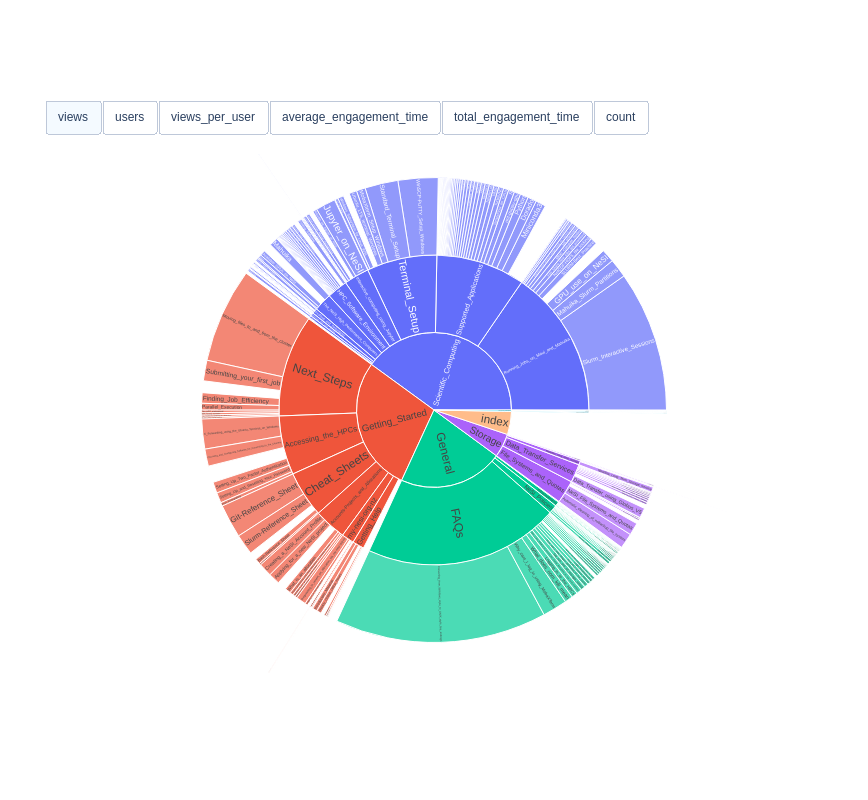

In [4]:
fig = make_subplots(rows=1, cols=1, specs=[
        [{"type": "sunburst"}], 
    ])
fig.update_layout(
    height=800,
    width=1000,
)
fig.add_trace(go.Sunburst(
    labels = data["page"],
    parents = data["parent"],
    values = data["views"],
    branchvalues="total",
    insidetextorientation='radial',
    hoverinfo='label+value+percent root+percent entry+percent parent'
))
fig.update_layout(
    updatemenus = [
        dict(
            type = "buttons",
            direction = "left",
            showactive = True,
            xanchor="left",
            yanchor="top",
            buttons = list([
                dict(
                    label = x,
                    method = 'restyle',
                    args = [{'values' : [data[x]]}]
                ) 
                for x in ['views','users','views_per_user','average_engagement_time','total_engagement_time', 'count']
            ])
        ),
    ]
)
fig.show()